# golub dataset

In [1]:
# install.packages("binom") # Installed from R studio as needs compilation
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("cancerclass")

In [2]:
library("ISLR") 
library("evaluomeR")
library("dplyr")
library("caret")

options(scipen=10)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

# Table of contents
* [Dataset](#dataset)
    * [Removing correlated](#correlated)
    * [Top 200](#top)
    * [evaluomeR](#evaluomer)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
nci60 = as.data.frame(NCI60$data)

In [4]:
head(nci60)
print(paste0("Rows: ", nrow(nci60)))
print(paste0("Columns: ", ncol(nci60)))

,1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,-0.65498050,...,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,-0.28501950,...,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,0.47501950,...,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,0.09501949,...,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,1.49001949,...,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,-0.24498050,...,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


[1] "Rows: 64"
[1] "Columns: 6830"


In [5]:
as.vector(unlist(as.data.frame(unique(NCI60$labs))))

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

In [6]:
nci60["labels"] = rownames(nci60)
nci60 = nci60[ , c("labels", names(nci60)[names(nci60) != "labels"])]
nci60["labels"] = NCI60$labs
colnames(nci60)[colnames(nci60) == 'labels'] <- 'Description'
#nci60 = nci60[!grepl("UNKNOWN", nci60$Description),] # Remove UNKNOWN
#nci60 = nci60[!grepl("PROSTATE", nci60$Description),] # Remove PROSTATE

In [7]:
unique(nci60$Description)
head(nci60)

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

,Description,1,2,3,4,5,6,7,8,9,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
V1,CNS,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,...,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,CNS,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,...,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,CNS,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,...,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,RENAL,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,...,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,BREAST,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,...,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,CNS,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,...,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


# Removing correlated <a class="anchor" id="correlated"></a>

In [8]:
data = nci60[-1]
R = cor(data)
head(R)

1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
1.00000000,0.3695226,0.22480296,0.07252510,-0.1116516,0.08243428,0.10254993,0.383263373,0.14670190,0.20051973,...,-0.001300883,-0.11062603,-0.10460492,-0.17531043,-0.20139510,-0.03978265,-0.036840429,-0.007934541,-0.08223300,-0.06899379
0.36952255,1.0000000,0.36508723,0.23474575,0.1564618,0.19000567,0.34730024,0.046214633,0.25977710,0.04362389,...,-0.019406447,-0.10082200,-0.03615309,0.00259474,0.01609672,-0.04861643,0.007148379,-0.083373460,-0.04229198,-0.04684439
0.22480296,0.3650872,1.00000000,0.23446349,0.1051751,0.02561423,0.10181136,0.008317433,-0.04439409,0.22355598,...,0.054222703,0.02633568,0.07871260,0.05115419,0.07527891,-0.12561155,-0.035143922,0.116059512,0.09578183,0.08030817
0.07252510,0.2347458,0.23446349,1.00000000,0.1392269,0.07215309,0.05029947,-0.117857727,0.03230132,-0.15742813,...,-0.183225740,-0.23724225,-0.19386999,-0.23074080,-0.08143472,-0.19606591,0.007614625,-0.050695933,-0.04277134,0.01004791
-0.11165163,0.1564618,0.10517512,0.13922691,1.0000000,0.25264831,0.24950135,-0.071547217,-0.04409090,-0.15049363,...,-0.157010467,-0.20287736,-0.14678837,-0.08016375,-0.11904921,0.09137401,0.069645970,-0.025193733,0.02818478,-0.04831955
0.08243428,0.1900057,0.02561423,0.07215309,0.2526483,1.00000000,0.47368945,0.224450477,0.16815275,0.07651512,...,-0.365049341,-0.29886202,-0.32601080,-0.17107287,-0.22933339,-0.17937081,-0.290953156,-0.223602202,-0.22389634,-0.21749344


In [9]:
cor_metrics = findCorrelation(R, cutoff = 1, verbose = FALSE, names=TRUE)
length(cor_metrics)

[1] 0

# Top 200 <a class="anchor" id="top"></a>

In [10]:
variance = sort(sapply(nci60[-1], var), decreasing = TRUE)  # Sorted gene variance
nci60_var = as.data.frame(variance)
nci60_var["Description"] = rownames(nci60_var)

In [11]:
top_number = 200
top_rows = nci60_var[c(1:top_number), ]
head(top_rows)

,variance,Description
4701,11.722255,4701
4700,11.323549,4700
6393,8.010836,6393
256,7.772252,256
4699,7.608615,4699
16,7.531815,16


In [12]:
row_list = as.list(top_rows["Description"])
top_row_list = unlist(setdiff(row_list, names(nci60)))
top_row_list

[1] "4701" "4700" "6393" "256"  "4699" "16"   "6149" "286"  "6415" "4354"
 [11] "6391" "113"  "252"  "257"  "6150" "5942" "6151" "5557" "243"  "6152"
 [21] "6392" "196"  "5805" "4353" "5556" "5980" "5948" "5732" "3957" "134" 
 [31] "5937" "5586" "2068" "4344" "5869" "4094" "6416" "6279" "755"  "5868"
 [41] "4154" "6278" "6156" "6087" "112"  "5760" "4288" "5804" "5943" "5692"
 [51] "2082" "224"  "6688" "4716" "6277" "4308" "6635" "3518" "2074" "2080"
 [61] "4244" "5555" "248"  "1390" "5705" "5979" "2081" "3525" "4093" "3936"
 [71] "133"  "4280" "5838" "975"  "6412" "754"  "5587" "1391" "4425" "4060"
 [81] "5803" "281"  "6430" "6689" "4426" "6710" "6084" "5910" "2083" "6429"
 [91] "301"  "3248" "4085" "6717" "5275" "5796" "5946" "4057" "1389" "5917"
[101] "4289" "3438" "287"  "4388" "5828" "6274" "6612" "5845" "5940" "5142"
[111] "4306" "3543" "5706" "267"  "5472" "188"  "4304" "5870" "6128" "6646"
[121] "5884" "6157" "6153" "6148" "6264" "5707" "5988" "5984" "4327" "251" 
[131] "242"  "5867" "5353" "5972" "1393" "5510" "5276" "5829" "3894" "5477"
[141] "5729" "5496" "6413" "5758" "5588" "4383" "1120" "6356" "6644" "5981"
[151] "5481" "6419" "5417" "1388" "5830" "6154" "5730" "266"  "4010" "5691"
[161] "5712" "273"  "3706" "6243" "5646" "5336" "6086" "5913" "3956" "3490"
[171] "5836" "111"  "5973" "5631" "6404" "247"  "6294" "5843" "5561" "78"  
[181] "756"  "1067" "4387" "6288" "5899" "229"  "245"  "5916" "5661" "5721"
[191] "6414" "5489" "4845" "6272" "5872" "3491" "1012" "6564" "6622" "124"

In [13]:
top_nci60 = nci60[, top_row_list]
#top_nci60["Description"] = rownames(top_nci60)
top_nci60["Description"] = nci60[rownames(top_nci60) %in% rownames(nci60), "Description"]
top_nci60 = top_nci60[ , c("Description", names(top_nci60)[names(top_nci60) != "Description"])] 
head(top_nci60)

,Description,4701,4700,6393,256,4699,16,6149,286,6415,...,6414,5489,4845,6272,5872,3491,1012,6564,6622,124
V1,CNS,5.770000,5.820000,5.4799900,-1.910000,4.760000,-2.37,0.000000,0.610000,5.230000,...,3.910000,1.990000,0.00000000,1.3199900,0.045000,0.00,0.000000,-1.3049900,1.210000,0.000000
V2,CNS,5.039961,5.069961,5.7299510,-1.980039,4.779961,0.00,-0.480039,-3.980039,5.329961,...,4.119961,2.609961,0.23498050,1.0299510,0.874961,0.00,-1.870039,-0.3750292,1.599961,-1.015039
V3,CNS,-1.440000,-1.030000,4.6299900,-0.580000,0.000000,0.00,2.060000,-1.580000,0.000000,...,-0.330000,0.200000,-0.06498051,2.1599900,1.445000,0.00,0.000000,1.0250100,-0.260000,0.000000
V4,RENAL,-2.420000,-2.420000,1.2999900,-1.880000,-2.590000,-1.02,5.190000,-4.880000,7.020000,...,5.250000,1.080000,0.39501950,3.2199900,2.365000,-0.91,2.430000,1.3150100,1.110000,0.000000
V5,BREAST,-2.955000,-2.955000,-1.0550098,-1.235000,-2.535000,0.00,7.425000,-3.235000,4.395000,...,3.205000,-1.155000,-0.64998051,0.5749902,3.320000,0.00,0.925000,-0.6299902,1.245000,0.000000
V6,CNS,0.000000,-3.180000,0.5899902,-3.050000,-1.170000,-0.05,4.230000,-5.050000,-0.220000,...,-0.400000,-0.970000,1.44501900,0.0000000,1.615000,0.61,0.700000,-0.8549902,1.360000,0.725000


# evaluomeR K analysis <a class="anchor" id="evaluomer"></a>

In [14]:
seed = 13606
k.range=c(3,10)
cbi = "clara"

# Stab
stab_range = stabilityRange(data=top_nci60, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
stab = standardizeStabilityData(stab_range)

# Qual
qual_range = qualityRange(data=top_nci60, k.range=k.range, 
                            seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
qual = standardizeQualityData(qual_range)

# K opt
k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
optimal_k = k_opt$Global_optimal_k
optimal_k_str = paste0("k_", optimal_k)
print(paste0("Optimal k: ", optimal_k))


Data loaded.
Number of rows: 64
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10

Data loaded.
Number of rows: 64
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
Processing metric: all_metrics

	Both Ks do not have a stable classification: '6', '8'

	Using '8' since it provides higher silhouette width



[1] "Optimal k: 8"


In [15]:
print(paste0("W/ ", cbi))
stab
qual
print(paste0("Stab in k=", optimal_k,": ", stab[optimal_k_str]))
print(paste0("Qual in k=", optimal_k,": ", qual[optimal_k_str]))

[1] "W/ clara"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.7207475,0.7319547,0.7172509,0.7375424,0.6993369,0.6877532,0.6528994,0.6322366


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.1301938,0.1466176,0.133847,0.1338489,0.1504899,0.1568005,0.137178,0.1391097


[1] "Stab in k=8: 0.687753156565657"
[1] "Qual in k=8: 0.156800514534358"


# Clusters

In [16]:
individuals_per_cluster = function(qualityResult) {
  qual_df = as.data.frame(assay(qualityResult))


  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [17]:
qual_cbi = qualityRange(data=top_nci60, k.range=k.range, 
                            seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
cluster_individuals = individuals_per_cluster(assay(qual_cbi[optimal_k_str]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
standardizeQualityData(qual_cbi)
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("---")
}


Data loaded.
Number of rows: 64
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


[1] "CBI: clara - k: 8"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
all_metrics,0.1301938,0.1466176,0.133847,0.1338489,0.1504899,0.1568005,0.137178,0.1391097


[1] "Cluster 1 : CNS,CNS,CNS,RENAL,BREAST,CNS,CNS,BREAST,NSCLC,NSCLC"
[1] "---"
[1] "Cluster 2 : RENAL,RENAL,RENAL,RENAL,RENAL,RENAL,RENAL,NSCLC,NSCLC,NSCLC,NSCLC"
[1] "---"
[1] "Cluster 3 : BREAST,MELANOMA,PROSTATE,OVARIAN,OVARIAN,OVARIAN,OVARIAN,OVARIAN,PROSTATE,COLON,COLON,COLON,COLON,COLON,COLON,COLON,NSCLC,NSCLC,NSCLC"
[1] "---"
[1] "Cluster 4 : RENAL,UNKNOWN,OVARIAN"
[1] "---"
[1] "Cluster 5 : LEUKEMIA,MELANOMA,BREAST,BREAST,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA"
[1] "---"
[1] "Cluster 6 : K562B-repro,K562A-repro,LEUKEMIA"
[1] "---"
[1] "Cluster 7 : LEUKEMIA,LEUKEMIA,LEUKEMIA,LEUKEMIA"
[1] "---"
[1] "Cluster 8 : MCF7A-repro,BREAST,MCF7D-repro,BREAST"
[1] "---"


# PCA <a class="anchor" id="pca"></a>

In [18]:
#PCA
print(length(cluster_individuals$InCluster))
print(nrow(top_nci60))
top_nci60["inCluster"] = as.numeric(cluster_individuals$InCluster)
unique(cluster_individuals$InCluster)

[1] 64
[1] 64


[[1]]
[1] "1"

[[2]]
[1] "2"

[[3]]
[1] "3"

[[4]]
[1] "4"

[[5]]
[1] "5"

[[6]]
[1] "6"

[[7]]
[1] "7"

[[8]]
[1] "8"

In [19]:
pca_matrix = top_nci60 %>% select(-Description, -inCluster)
head(pca_matrix)

,4701,4700,6393,256,4699,16,6149,286,6415,4354,...,6414,5489,4845,6272,5872,3491,1012,6564,6622,124
V1,5.770000,5.820000,5.4799900,-1.910000,4.760000,-2.37,0.000000,0.610000,5.230000,1.830000,...,3.910000,1.990000,0.00000000,1.3199900,0.045000,0.00,0.000000,-1.3049900,1.210000,0.000000
V2,5.039961,5.069961,5.7299510,-1.980039,4.779961,0.00,-0.480039,-3.980039,5.329961,0.999961,...,4.119961,2.609961,0.23498050,1.0299510,0.874961,0.00,-1.870039,-0.3750292,1.599961,-1.015039
V3,-1.440000,-1.030000,4.6299900,-0.580000,0.000000,0.00,2.060000,-1.580000,0.000000,3.130000,...,-0.330000,0.200000,-0.06498051,2.1599900,1.445000,0.00,0.000000,1.0250100,-0.260000,0.000000
V4,-2.420000,-2.420000,1.2999900,-1.880000,-2.590000,-1.02,5.190000,-4.880000,7.020000,3.850000,...,5.250000,1.080000,0.39501950,3.2199900,2.365000,-0.91,2.430000,1.3150100,1.110000,0.000000
V5,-2.955000,-2.955000,-1.0550098,-1.235000,-2.535000,0.00,7.425000,-3.235000,4.395000,2.535000,...,3.205000,-1.155000,-0.64998051,0.5749902,3.320000,0.00,0.925000,-0.6299902,1.245000,0.000000
V6,0.000000,-3.180000,0.5899902,-3.050000,-1.170000,-0.05,4.230000,-5.050000,-0.220000,0.240000,...,-0.400000,-0.970000,1.44501900,0.0000000,1.615000,0.61,0.700000,-0.8549902,1.360000,0.725000


In [20]:
pca_result <- prcomp(pca_matrix, scale. = TRUE)

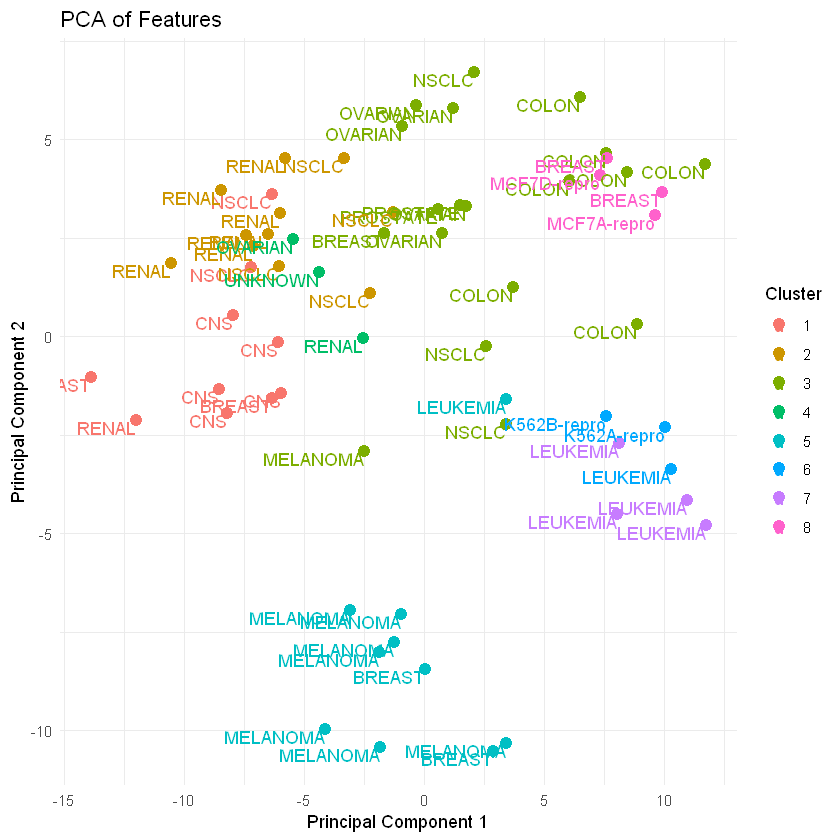

In [21]:
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_nci60$inCluster)
pca_df$Individual <- top_nci60$Description

# Plot PCA results

ggplot2::ggplot(pca_df, ggplot2::aes(x = PC1, y = PC2, color = Cluster, label = Individual)) +
  ggplot2::geom_point(size = 3) +
  ggplot2::geom_text(vjust = 1, hjust = 1) +
  ggplot2::labs(title = "PCA of Features",
       x = "Principal Component 1",
       y = "Principal Component 2") +
  ggplot2::theme_minimal()

# Sensitivity <a class="anchor" id="sensitivity"></a>

In [22]:
library("MLmetrics")


Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:RSKC':

    Sensitivity

The following object is masked from 'package:base':

    Recall



In [23]:
top_nci60["Class"] = top_nci60["Description"]
head(top_nci60)[, c("Description", "Class")]
#as.vector(unlist(unique(top_nci60["Class"])))

,Description,Class
V1,CNS,CNS
V2,CNS,CNS
V3,CNS,CNS
V4,RENAL,RENAL
V5,BREAST,BREAST
V6,CNS,CNS


In [24]:
# KMEANS
# k=8
# level_mapping <- c("NSCLC" = 1, "CNS" = 2, "BREAST" = 3,
#                  "MCF7A-repro" = 3, "MCF7D-repro" = 3, "RENAL" = 4, 
#                  "LEUKEMIA" = 5, "K562B-repro" = 5, "K562A-repro" = 5, 
#                  "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8
#                   )
# k=9
# level_mapping <- c("NSCLC" = 8, "CNS" = 2, "BREAST" = 1,
#                   "MCF7A-repro" = 1, "MCF7D-repro" = 1, "RENAL" = 4,
#                   "LEUKEMIA" = 5, "K562B-repro" = 3, "K562A-repro" = 3, 
#                   "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8,
#                    "PROSTATE"= 9
#                    )
#k=10
# level_mapping <- c("NSCLC" = 10, "CNS" = 2, "BREAST" = 1,
#                   "MCF7A-repro" = 1, "MCF7D-repro" = 1, "RENAL" = 4, 
#                   "LEUKEMIA" = 3, "K562B-repro" = 5, "K562A-repro" = 5, 
#                   "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8,
#                    "PROSTATE"= 7, "UNKNOWN" = 9
#                    )


In [25]:
# CLARA
# k=6 (8 cat.)
# level_mapping <- c("NSCLC" = 2, "CNS" = 1, "BREAST" = 5,
#                  "MCF7A-repro" = 5, "MCF7D-repro" = 5, "RENAL" = 2, 
#                  "LEUKEMIA" = 4, "K562B-repro" = 4, "K562A-repro" = 4, 
#                  "MELANOMA" = 6,  "COLON" = 3, "OVARIAN" = 3
#                   )
# k=8 (10 cat.)
level_mapping <- c("NSCLC" = 2, "CNS" = 1, "BREAST" = 8,
                  "MCF7A-repro" = 8, "MCF7D-repro" = 8, "RENAL" = 4, 
                  "LEUKEMIA" = 7, "K562B-repro" = 6, "K562A-repro" = 6, 
                  "MELANOMA" = 5,  "COLON" = 3, "OVARIAN" = 3,
                   "PROSTATE"= 3, "UNKNOWN" = 4
             )
map_strings_to_numbers <- function(strings) {
    return(as.numeric(level_mapping[strings]))
}

In [26]:
top_nci60["Class_n"] = lapply(top_nci60["Class"], map_strings_to_numbers)
head(top_nci60)[, c("Description", "Class", "inCluster", "Class_n")]

,Description,Class,inCluster,Class_n
V1,CNS,CNS,1,1
V2,CNS,CNS,1,1
V3,CNS,CNS,1,1
V4,RENAL,RENAL,1,4
V5,BREAST,BREAST,1,8
V6,CNS,CNS,1,1


In [27]:
top_nci60[top_nci60$Description=="NSCLC", c("Description", "Class", "inCluster", "Class_n")]

,Description,Class,inCluster,Class_n
V9,NSCLC,NSCLC,1,2
V10,NSCLC,NSCLC,1,2
V19,NSCLC,NSCLC,2,2
V31,NSCLC,NSCLC,2,2
V32,NSCLC,NSCLC,2,2
V33,NSCLC,NSCLC,2,2
V53,NSCLC,NSCLC,3,2
V54,NSCLC,NSCLC,3,2
V55,NSCLC,NSCLC,3,2


In [28]:
# Getting a vector of clusters
actual = as.factor(as.vector(unlist(top_nci60["Class_n"])))
predicted <- factor(as.vector(unlist(top_nci60["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 1 1 1 4 8 1 1 8 2 2 4 4 4 4 4 4 4 8 2 4 4 3 5 3 3 3 3 3 3 3 2 2 2 7 6 6 7 7
[39] 7 7 7 3 3 3 3 3 3 3 8 8 8 8 2 2 2 5 8 8 5 5 5 5 5 5
Levels: 1 2 3 4 5 6 7 8

[1] "predicted"


[1] 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 2 4 4 4 3 3 3 3 3 3 3 3 2 2 2 5 6 6 6 7
[39] 7 7 7 3 3 3 3 3 3 3 8 8 8 8 3 3 3 5 5 5 5 5 5 5 5 5
Levels: 1 2 3 4 5 6 7 8

In [29]:
sens <- Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 100.00%"


# CER <a class="anchor" id="cer"></a>

In [30]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 13.49%"
